# Part II: Finding influencers from Reddit

## Import Packages and Dataset

In [30]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import zstandard as zstd
import io

In [33]:
# Import the submissions
filepath = "/Users/sunnygao/Desktop/INSY670/Group Assignment/virtualbox_submissions.zst"
df_submission= pd.read_json(filepath,compression=dict(method='zstd', max_window_size=2147483648), lines=True)

In [34]:
df_submission.head()

,downs,link_flair_text,distinguished,media,url,link_flair_css_class,id,edited,num_reports,created_utc,...,removed_by,removed_by_category,treatment_tags,upvote_ratio,is_created_from_ads_ui,retrieved_utc,top_awarded_type,url_overridden_by_dest,poll_data,call_to_action
0,1.0,None,None,None,http://www.reddit.com/r/virtualbox/comments/ij...,None,ijmve,0,NaN,1310091404,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,None,None,None,http://en.wikipedia.org/wiki/VirtualBox,None,ofe9w,0,NaN,1326460622,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.0,None,None,None,https://www.virtualbox.org/,None,ofdwo,0,NaN,1326459672,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.0,None,None,None,http://www.reddit.com/r/virtualbox/comments/rb...,None,rbzsk,0,NaN,1332631515,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.0,None,None,None,http://blog.peileppe.com/2012/04/virtualbox-ap...,None,s7slg,0,NaN,1334317607,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
# Import the comments
filepath = "/Users/sunnygao/Desktop/INSY670/Group Assignment/virtualbox_comments.zst"
df_comments= pd.read_json(filepath,compression=dict(method='zstd', max_window_size=2147483648), lines=True)

In [36]:
df_comments.head()

,controversiality,archived,parent_id,edited,ups,subreddit,score,author,score_hidden,retrieved_on,...,associated_award,collapsed_because_crowd_control,author_premium,treatment_tags,top_awarded_type,comment_type,collapsed_reason_code,retrieved_utc,author_is_blocked,unrepliable_reason
0,0,1.0,t3_ofe9w,0,1.0,virtualbox,1,[deleted],0.0,1.428173e+09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,1.0,t3_y5o1o,0,1.0,virtualbox,1,brazen,0.0,1.429628e+09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,1.0,t3_19fgoa,0,2.0,virtualbox,2,roknir,0.0,1.431443e+09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,1.0,t1_c8njp55,0,2.0,virtualbox,2,[deleted],0.0,1.431445e+09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,1.0,t3_19pwi5,0,1.0,virtualbox,1,crustang,0.0,1.431491e+09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Merge the files and construct the data

In [37]:
# Count the number of missing values in the 'parent_id' column
num_missing_parent_id = df_comments['parent_id'].isnull().sum()

print(f"Number of missing values in 'parent_id': {num_missing_parent_id}")

Number of missing values in 'parent_id': 0


In [38]:
# Count the number of missing values in the 'link_id' column
num_missing_parent_id = df_comments['link_id'].isnull().sum()

print(f"Number of missing values in 'link_id': {num_missing_parent_id}")

Number of missing values in 'link_id': 0


In [39]:
df_submission["id"].head()

0    ijmve
1    ofe9w
2    ofdwo
3    rbzsk
4    s7slg
Name: id, dtype: object

In [40]:
"""

In Reddit's API data structure, submission IDs are prefixed with "t3_", and comment IDs are prefixed with "t1_".
The link_id column contains identifiers that match the id column of the submissions to which the comments are linked.
The parent_id will either be a submission's ID (prefixed with something like t3_ for submissions) or another comment's ID (prefixed with something like t1_ for comments).

"""

# Prepend 't3_' to match the format in comments' 'link_id' and 'parent_id'
df_submission['full_id'] = 't3_' + df_submission['id']
df_comments['full_id'] = 't1_' + df_comments['id']

# Map submission and comment IDs to authors
id_to_author_map = {**df_submission.set_index('full_id')['author'].to_dict(),
                    **df_comments.set_index('full_id')['author'].to_dict()}

In [41]:
# Determine 'parent_author' based on 'parent_id'
df_comments['parent_id_author'] = df_comments['parent_id'].map(id_to_author_map)
df_comments['parent_id_author'] = df_comments['parent_id_author'].fillna('unknown')

In [42]:
# Add 'child_id' to comments (which is just the 'id' column)
df_comments['child_id'] = df_comments['id']

# Determine 'link_type'
def determine_link_type(row, id_to_author_map):
    if row['parent_id'].startswith('t3'):
        return 'respond to a submission'
    elif row['parent_id'].startswith('t1'):
        return 'respond to a comment'
    return 'unknown'

df_comments['link_type'] = df_comments.apply(lambda row: determine_link_type(row, id_to_author_map), axis=1)

In [70]:
comments_data = df_comments[['author', 'parent_id_author', "link_type"]]
# comments_data["parent_id"] = [x.strip()[3:] for x in comments_data["parent_id"]]

In [71]:
comments_data

,author,parent_id_author,link_type
0,[deleted],[deleted],respond to a submission
1,brazen,brazen,respond to a submission
2,roknir,[deleted],respond to a submission
3,[deleted],roknir,respond to a comment
4,crustang,crustang,respond to a submission
...,...,...,...
34816,[deleted],AlexandraWheeler1,respond to a submission
34817,ModzRSoftBitches,AlexandraWheeler1,respond to a comment
34818,AlexandraWheeler1,ModzRSoftBitches,respond to a comment
34819,apetc,rabbitdovahkiin,respond to a comment


## Calculate the degree, betweenness and closeness of each node in the above network.

In [72]:
edges = list(zip(comments_data['parent_id_author'], comments_data['author']))
# Create the network
G = nx.Graph()
G.add_edges_from(edges)

In [73]:
# Calculate network metrics
# Degree
degrees = dict(G.degree())

# Betweenness Centrality
betweenness = nx.betweenness_centrality(G)

# Closeness Centrality
closeness = nx.closeness_centrality(G)

In [74]:
# Print the top 10 nodes by degree centrality
print("Top 10 nodes by degree:")
for node, degree in sorted(degrees.items(), key=lambda x: x[1], reverse=True)[:10]:
    print(node, degree)

# Print the top 10 nodes by betweenness centrality
print("\nTop 10 nodes by betweenness centrality:")
for node, betw in sorted(betweenness.items(), key=lambda x: x[1], reverse=True)[:10]:
    print(node, betw)

# Print the top 10 nodes by closeness centrality
print("\nTop 10 nodes by closeness centrality:")
for node, clos in sorted(closeness.items(), key=lambda x: x[1], reverse=True)[:10]:
    print(node, clos)

Top 10 nodes by degree:
AutoModerator 3139
Face_Plant_Some_More 2641
[deleted] 1297
MrAureliusR 825
AdversarialPossum42 353
mrkleen340 264
officer_terrell 260
boli99 193
antdude 113
zfsbest 92

Top 10 nodes by betweenness centrality:
[deleted] 0.33811551609613744
AutoModerator 0.3216141661296836
Face_Plant_Some_More 0.29491451971143495
MrAureliusR 0.10512814310354432
mrkleen340 0.058797241668647714
boli99 0.034594331066309665
AdversarialPossum42 0.031919787559157795
officer_terrell 0.027899828201047118
antdude 0.02374083815948821
Phydoux 0.013063386073511313

Top 10 nodes by closeness centrality:
Face_Plant_Some_More 0.46428697375580086
[deleted] 0.4627965278499617
AutoModerator 0.4598956317721021
MrAureliusR 0.41414248304122164
antdude 0.3881632096600813
Phydoux 0.38797994091142207
Rachid90 0.38463841736116455
Dougolicious 0.3802598402824581
AdversarialPossum42 0.37952222189654167
unix21311 0.37770799542672917


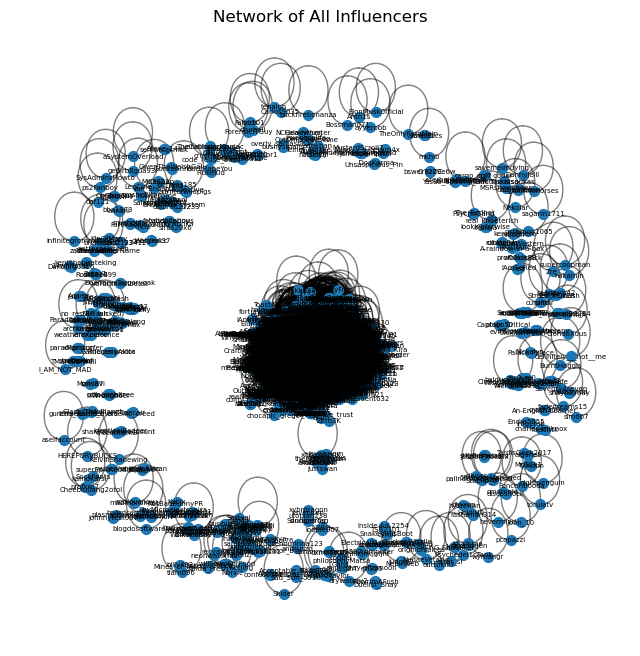

In [75]:
# Visualize the network
plt.figure(figsize=(8, 8))  
pos = nx.spring_layout(G, seed=42)  # For consistent layout
nx.draw_networkx_nodes(G, pos, node_size=50)  # Adjust node size
nx.draw_networkx_edges(G, pos, alpha=0.5)  # Adjust edge transparency
nx.draw_networkx_labels(G, pos, font_size=5)  # Adjust label font size
plt.title("Network of All Influencers")
plt.axis('off')  # Hide the axes
plt.show()